In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import galaxy_experiments_lib as galaxy_lib

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=1, max_galaxies=1, num_bands=5, num_images=100)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

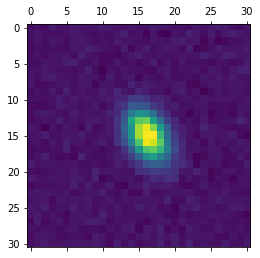

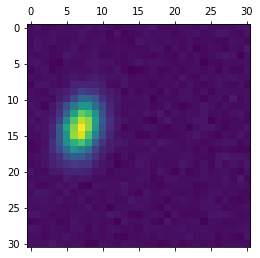

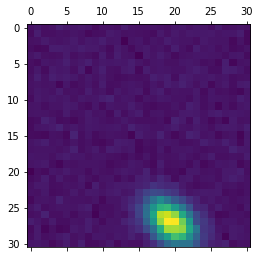

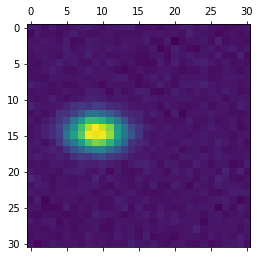

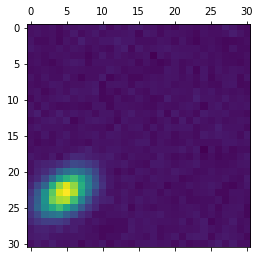

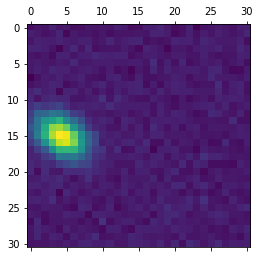

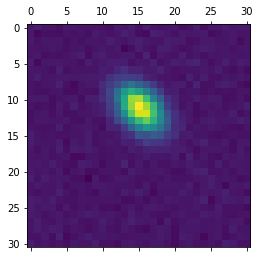

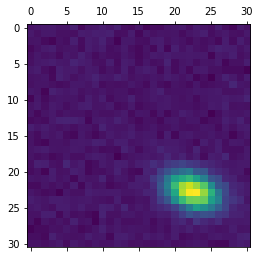

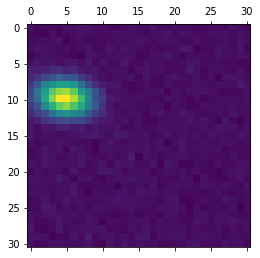

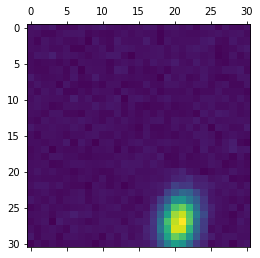

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
# The VAE
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

load_warm_start_params = False
if load_warm_start_params: 
    state_dict_attn = torch.load('../galaxy_warm_starts/attn_enc_init.dat', map_location='cpu')
    galaxy_vae.attn_enc.load_state_dict(state_dict_attn, strict=False)

    state_dict_enc = torch.load('../galaxy_warm_starts/galaxy_enc_init.dat', map_location='cpu')
    galaxy_vae.enc.load_state_dict(state_dict_enc, strict=False)

    state_dict_dec = torch.load('../galaxy_warm_starts/galaxy_dec_init.dat', map_location='cpu')
    galaxy_vae.dec.load_state_dict(state_dict_dec, strict=False)

In [8]:
galaxy_rnn = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [71]:
load_from_results = True
if load_from_results: 
    state_dict = torch.load('../galaxy_results/topk5/galaxy_vae_topk5_epoch80.dat', map_location='cpu')
    galaxy_rnn.load_state_dict(state_dict, strict = True)

In [72]:
galaxy_rnn.eval(); 
galaxy_rnn.one_galaxy_vae.eval(); 

In [73]:
_, loss = galaxy_rnn.get_pm_loss(image = images_batch1, 
                                    image_so_far = backgrounds_batch1, 
                                    var_so_far = backgrounds_batch1, 
                                    alpha = 0.0, 
                                    topk = 0, 
                                    use_baseline = False)

print(loss)

tensor(35158.7891)


In [74]:
galaxy_lib.train_epoch(galaxy_rnn, train_loader,
            alpha = 0.0,
            topk = 0,
            use_baseline = False,
            train = False)

tensor(30798.3164)

In [69]:
pixel_probs = galaxy_rnn.get_pixel_probs(images_batch1, backgrounds_batch1)

(array([62.,  9.,  2.,  5.,  5.,  1.,  1.,  0.,  1.,  1.]),
 array([0.01015902, 0.08950949, 0.16885996, 0.24821044, 0.32756091,
        0.40691138, 0.48626185, 0.56561232, 0.64496279, 0.72431326,
        0.80366373]),
 <a list of 10 Patch objects>)

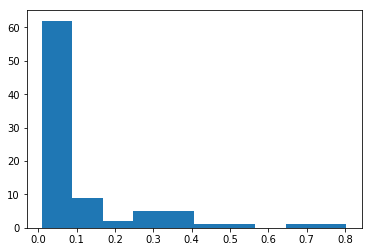

In [70]:
foo = pixel_probs.detach().numpy().flatten()
plt.hist(foo[foo > 1e-2])

In [38]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [39]:
cond_loss, recon_mean, recon_var = galaxy_rnn.get_loss_conditional_a(images_batch1 - backgrounds_batch1,
                                                                     backgrounds_batch1, 
                                                                     backgrounds_batch1, 
                                                                     map_pixel_loc)

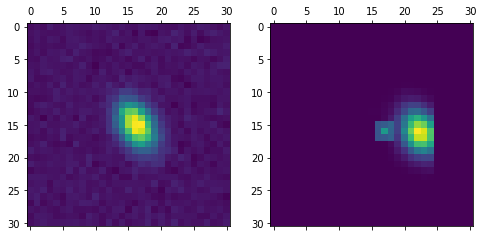

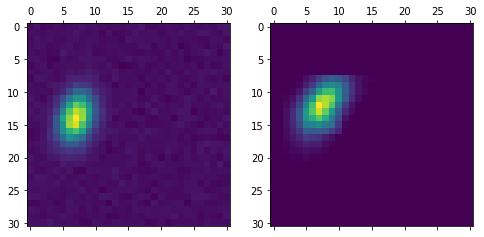

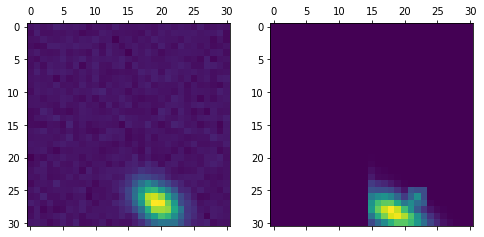

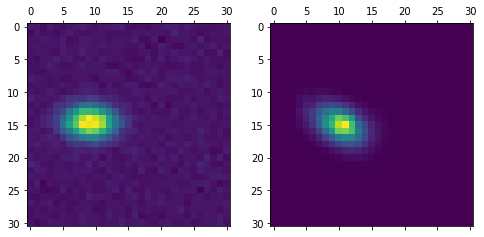

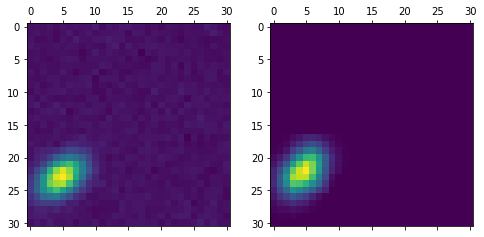

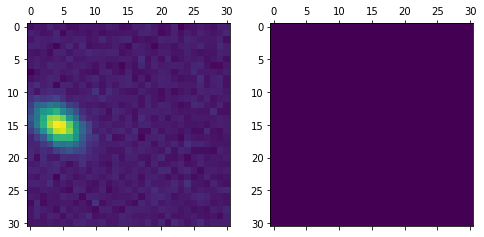

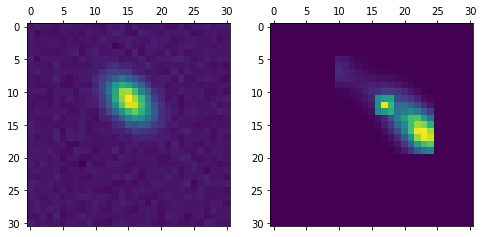

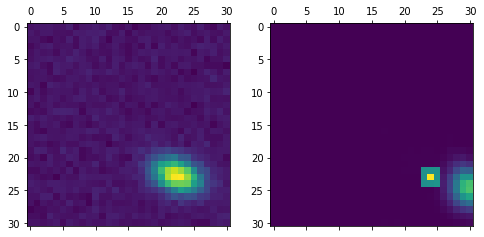

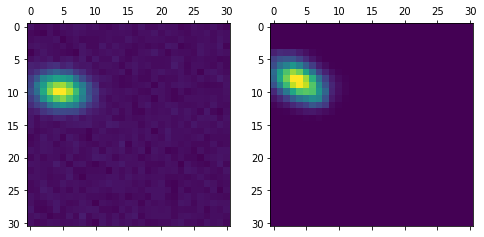

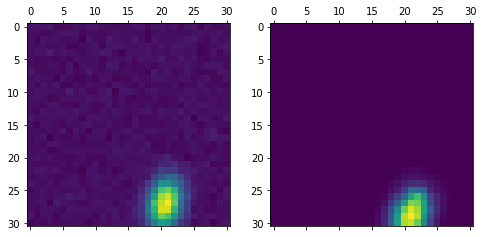

In [40]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())
